# Approach 2

Getting back into it after some time with a new approach for finding patterns. Initial exploration and analysis.

### Init

In [1]:
import polars as pl
from polars import selectors as cs
from matplotlib import pyplot as plt
import os
import statsmodels.api as sm
import numpy as np

DEBUG = False

### Load and unpivot

In [2]:
path = os.path.join('data', 'silver', 'prices_with_nrdy')

df = pl.read_parquet(path)

In [3]:
display(df)

date,ticker,price
date,str,f64
1994-03-18,"""SCSC""",1.71875
1994-03-21,"""SCSC""",1.90625
1994-03-22,"""SCSC""",1.9375
1994-03-23,"""SCSC""",2.09375
1994-03-24,"""SCSC""",2.09375
…,…,…
2024-04-26,"""NRDY""",2.76
2024-04-29,"""NRDY""",2.71
2024-04-30,"""NRDY""",2.59


### Plot price over time

In [4]:
def plot_price(df, ticker=None, x='date', y='price'):
    if not ticker:
        ticker = ''

    dates = df[x]
    prices = df[y]

    fig, ax = plt.subplots()
    ax.plot(dates, prices)
    # ax.scatter(dates, prices, s=5)
    plt.title(ticker)
    plt.show()
    

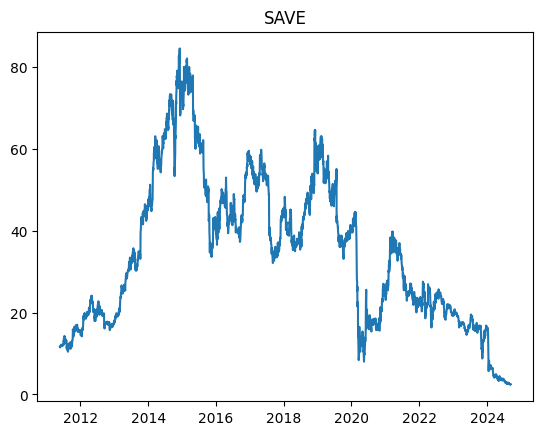

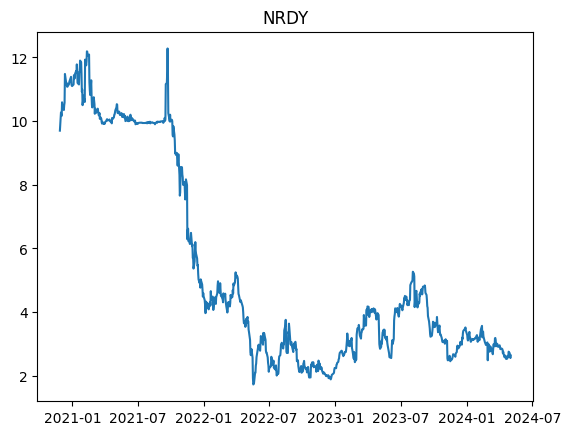

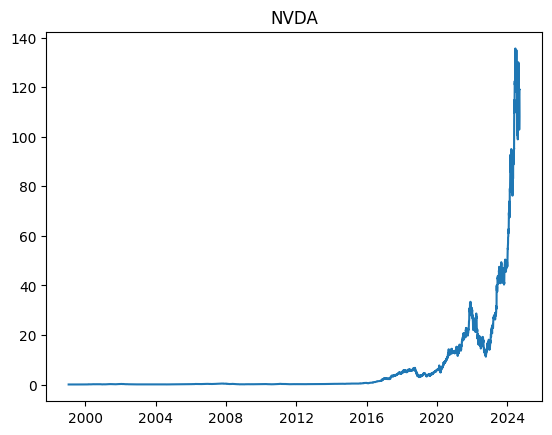

In [5]:
test_tickers = ['NRDY', 'NVDA', 'SAVE']

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

for ticker, group_df in filtered_df.group_by('ticker'):
    plot_price(group_df, ticker[0])



### Detrending

In [6]:
def plot_detrended(ticker, actuals, predictions, adjusted):
    x = list(range(0, len(actuals)))

    fig, ax = plt.subplots()
    ax.scatter(x, actuals, s=5)
    ax.plot(x, predictions)
    ax.plot(x, adjusted)
    ax.set_title(ticker)
    plt.show()

In [7]:
def detrend_lin_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    ticker = df['ticker'][0]

    df = df.sort(pl.col('date'))

    rows, cols = df.shape

    # create X and y
    X = list(range(0, rows))
    X = sm.add_constant(X)
    y = df['price'].to_numpy()

    # fit model
    model = sm.OLS(y, X)
    results = model.fit()

    # make predictions
    predictions = results.predict()

    # detrend using model predictions
    df = df.with_columns(pl.col('price') - predictions)

    if DEBUG:
        print(results.summary())

        plot_detrended(ticker, y, predictions, df['price'])
    
    return df



In [8]:
def detrend_exp_reg(df):
    assert 'date' in df.columns
    assert 'price' in df.columns

    df = df.with_columns(pl.col('price').log1p())

    df = detrend_lin_reg(df)

    return df



In [9]:
# DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_lin_reg)

In [10]:
# DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_exp_reg)

Regression detrending isn't working well on tickers that have two distinct trends. 

In [11]:
def detrend_moving_avg(df):
    WINDOW_SIZE = 5

    # checks
    assert 'date' in df.columns
    assert 'price' in df.columns
    assert 'ticker' in df.columns
    assert df['ticker'].unique().count() == 1

    # get ticker
    ticker = df['ticker'][0]

    # calculate rolling average
    df = df.sort(pl.col('date')) \
    .with_columns(pl.col('price').rolling_mean(WINDOW_SIZE).alias('rolling_avg')) \
    .with_columns((pl.col('price') - pl.col('rolling_avg')).alias('adjusted'))


    if DEBUG:
        plot_detrended(ticker, df['price'], df['rolling_avg'], df['adjusted'])

    # remove and rename unneeded columns
    df = df.select(pl.col('date'), pl.col('ticker'), pl.col('adjusted').alias('price'))
    
    return df



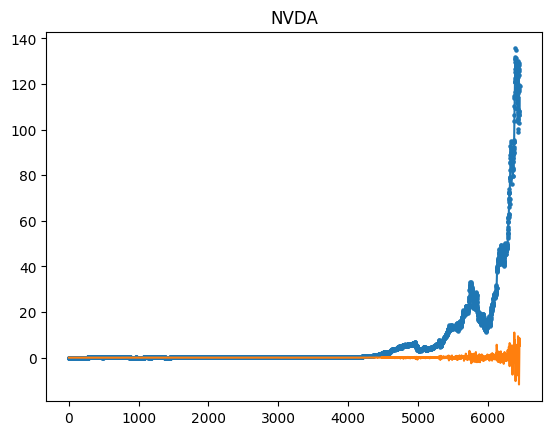

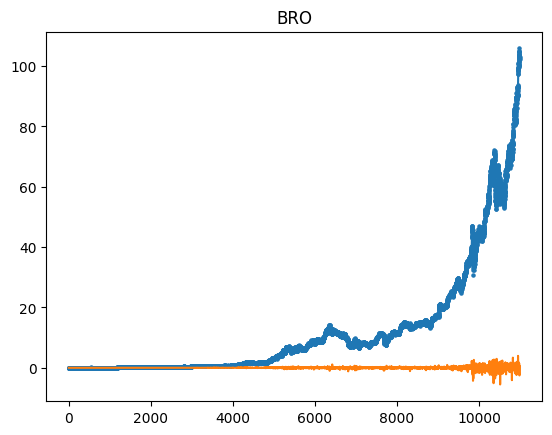

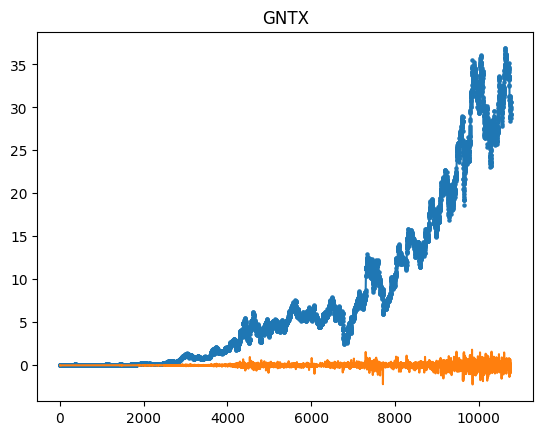

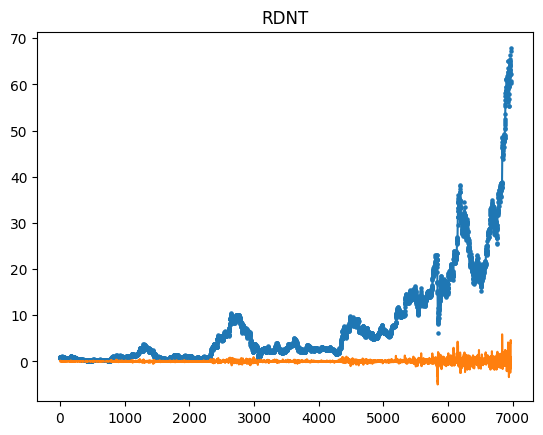

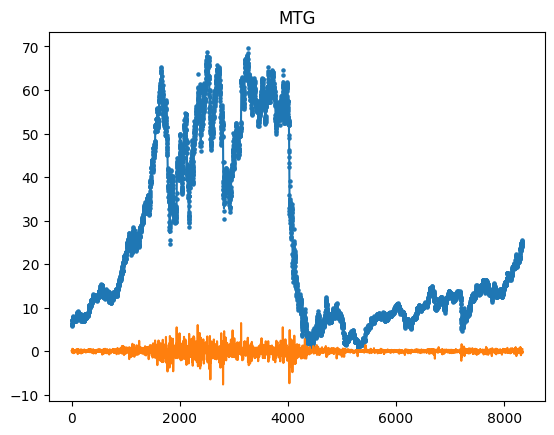

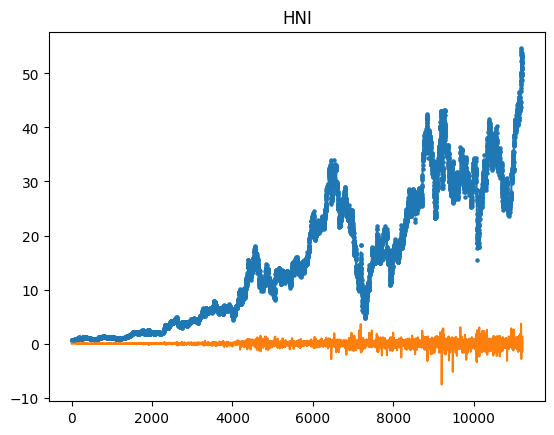

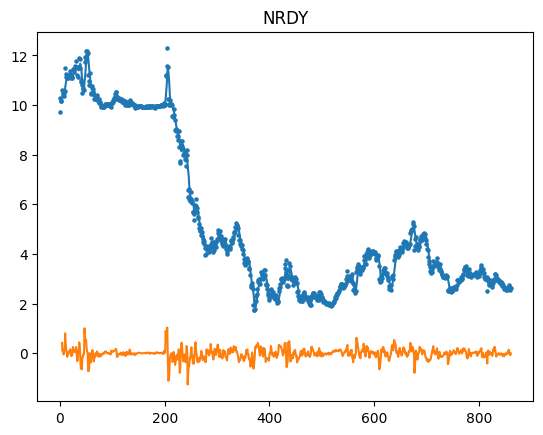

In [12]:
DEBUG = True
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:5]

detrended_df = df.filter(pl.col('ticker').is_in(test_tickers))

detrended_df = detrended_df.group_by('ticker').map_groups(detrend_moving_avg)

Rolling average seems to be the best option.

In [30]:
def fft(df):
    a = df['price'].to_numpy()

    # a = np.sin(list(range(0, a.shape[-1])))

    sp = np.fft.fft(a)

    if DEBUG:
        freq = np.fft.fftfreq(a.shape[-1])

        fig, ax = plt.subplots()
        plt.scatter(freq, sp.imag)

        plt.show()
        display(freq)
    return df

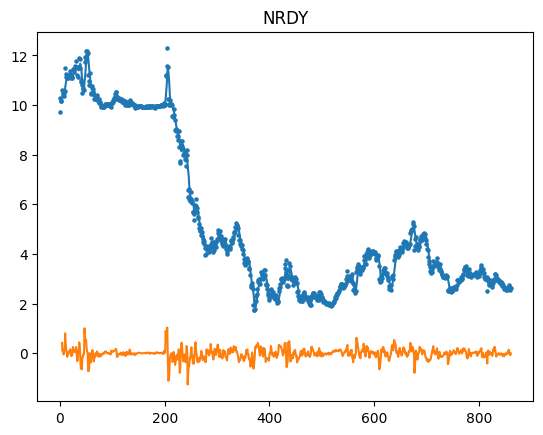

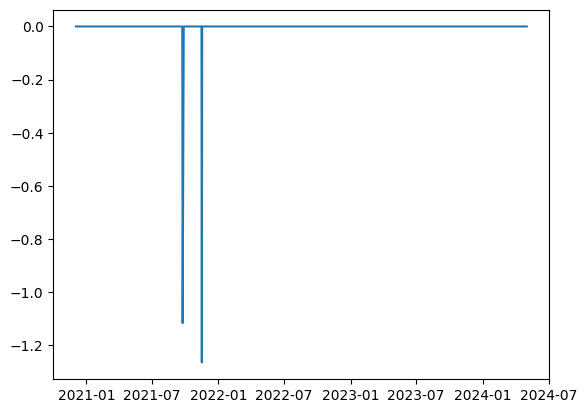

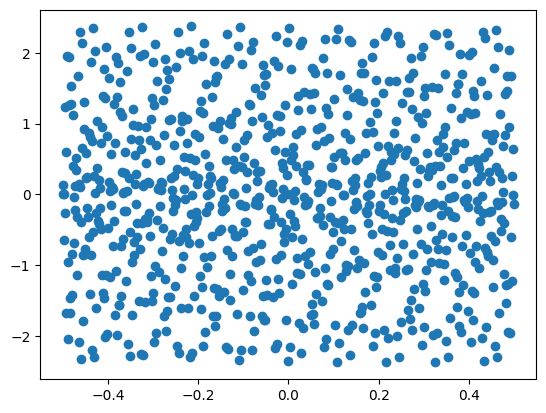

array([ 0.        ,  0.0011655 ,  0.002331  ,  0.0034965 ,  0.004662  ,
        0.00582751,  0.00699301,  0.00815851,  0.00932401,  0.01048951,
        0.01165501,  0.01282051,  0.01398601,  0.01515152,  0.01631702,
        0.01748252,  0.01864802,  0.01981352,  0.02097902,  0.02214452,
        0.02331002,  0.02447552,  0.02564103,  0.02680653,  0.02797203,
        0.02913753,  0.03030303,  0.03146853,  0.03263403,  0.03379953,
        0.03496503,  0.03613054,  0.03729604,  0.03846154,  0.03962704,
        0.04079254,  0.04195804,  0.04312354,  0.04428904,  0.04545455,
        0.04662005,  0.04778555,  0.04895105,  0.05011655,  0.05128205,
        0.05244755,  0.05361305,  0.05477855,  0.05594406,  0.05710956,
        0.05827506,  0.05944056,  0.06060606,  0.06177156,  0.06293706,
        0.06410256,  0.06526807,  0.06643357,  0.06759907,  0.06876457,
        0.06993007,  0.07109557,  0.07226107,  0.07342657,  0.07459207,
        0.07575758,  0.07692308,  0.07808858,  0.07925408,  0.08

In [31]:
test_tickers = ['NRDY', 'NVDA'] + df['ticker'].unique().to_list()[:1]
test_tickers = test_tickers[:1]

filtered_df = df.filter(pl.col('ticker').is_in(test_tickers))

DEBUG = True
detrended_df = filtered_df.group_by('ticker').map_groups(detrend_moving_avg).drop_nulls().with_columns(pl.when(abs(pl.col('price')) > 1.1).then(pl.col('price')).otherwise(0).alias('price'))

plot_price(detrended_df)
DEBUG = True
fft_df = detrended_df.group_by('ticker').map_groups(fft)
# display(fft_df)